# Introduction

We work with **Panama Dataset** on Kaggle. Access the data from [here](https://www.kaggle.com/datasets/ernestojaguilar/shortterm-electricity-load-forecasting-panama). Some useful resources to make sense of the data are, *A Practitioner's Guide to Short-Term Load Forecast Modeling* and the paper associated with the dataset *'Short-Term Electricity Load Forecasting with Machine Learning'* by Ernesto Aguilar Madrid 1 and Nuno Antonio

The files of interest are the following:  
1. continuous dataset.csv
2. test_dataframes.xlsx
3. train_dataframes.xlsx
4. weekly pre-dispatch forecast.csv

We consider the “net-demand” of electricity from date 03/01/2015 1:00:00 AM to 27/06/2020 12:00:00 AM. This is a total of 2002 days.Since the demand of electricity is given at every one-hour interval, we have the total datapoints:

    24 x 2002  = 48048

All data points can be found in  “continuous dataset.csv”.

# Train and Test Dataset Split for Time Series

For time-series, we implement the **walk-forward Train/Test splits** rather than traditional test-train splits.

These splits can be found in `test_dataframes.xlsx` and `train_dataframes.xlsx`.

In traditional ML paradigms, we randomly select subsets of data for the validation and test sets. But in time-series data, each data point is dependent on its past values. Therefore, it is important that when creating a validation set, we respect the seqential order within the data.

Since we are measuring electricity demand on an hourly basis, this means that for each split, we are predicting the total number of `7 x 24 = 168` datapoints found in `test_dataframes`. The test_dataframes actually contain 14 of these weeks, so the total number of values in the 14 sheets is the following: `14 x 168 = 2352`

The weeks for which we are predicting are from Week 15, Apr 2019 to Week 24 Jun 2020.  For each of these splits, we are considering all the values before the particular week on which we test our data as our training set. This is the reason why are our training-set continues to increase (because for the next week prediction, the prior week data now becomes the training data)



# Loss Functions:

1. $MAPE = \frac{1}{n} \sum_{h=1} {n} \left| \frac{A_h - F_h}{A_h} \right| \times 100\%$: Measures the average percentage error between actual and forecasted loads.
2. $RMSE = \sqrt{\frac{1}{n} \sum_{h=1}^{n} (A_h - F_h)^2} \quad \text{MWh}$: Penalizes large errors more than small ones, measuring absolute forecasting accuracy in MWh.
3. $\text{Peak} = \left| \frac{\max(A) - \max(F)}{\max(A)} \right| \times 100\%$: Evaluates forecasting accuracy at the highest load point.
4. $\text{Valley} = \left| \frac{\min(A) - \min(F)}{\min(A)} \right| \times 100\% $: Measures forecasting performance at the lowest demand periods.
5. $ \text{Energy} = \left| \frac{\sum_{h=1}^{n} A_h - \sum_{h=1}^{n} F_h}{\sum_{h=1}^{n} A_h} \right| \times 100\% $: Assesses the overall energy discrepancy between actual and forecasted loads over the entire period.



In [ ]:
# Implementing Mape
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

# Implementing RMSE

def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    return rmse

# Implementing Peak Load

def peak_load_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    peak_load_true = np.max(y_true)
    plape = np.abs((peak_load_true - np.max(y_pred)) / peak_load_true) * 100
    return plape

# Implementing Valey load
def value_load_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    peak_min_true = np.min(y_true)
    vlape = np.abs((peak_min_true - np.min(y_pred)) / peak_min_true) * 100
    return vlape


# Implementing Energy absolute percent error
def energy_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    total_energy_true = np.sum(y_true)
    total_energy_pred = np.sum(y_pred)
    eape = np.abs((total_energy_true - total_energy_pred) / total_energy_true) * 100

    return eape

# Data Exploration

Let us first visualize the Natural Demand of Electricity on an hourly basis focusing on 3 distinct timestamps:

- Yearly Basis
- Monthly Basis
- Daily Basis

Examining the Natural Demand at these intervals will enable us to uncover key trends in electricity consumption throughout the year, month, and day.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

color_pal = sns.color_palette() #will use this for plotting



In [ ]:
file_path = "/content/drive/My Drive/Datasets/Panama_Dataset/continuous dataset.csv"
df = pd.read_csv(file_path)
df.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [ ]:
#For time series data, its common to set our index to be the date time.
df = df.set_index("datetime")
df.index = pd.to_datetime(df.index)
df.index

DatetimeIndex(['2015-01-03 01:00:00', '2015-01-03 02:00:00',
               '2015-01-03 03:00:00', '2015-01-03 04:00:00',
               '2015-01-03 05:00:00', '2015-01-03 06:00:00',
               '2015-01-03 07:00:00', '2015-01-03 08:00:00',
               '2015-01-03 09:00:00', '2015-01-03 10:00:00',
               ...
               '2020-06-26 15:00:00', '2020-06-26 16:00:00',
               '2020-06-26 17:00:00', '2020-06-26 18:00:00',
               '2020-06-26 19:00:00', '2020-06-26 20:00:00',
               '2020-06-26 21:00:00', '2020-06-26 22:00:00',
               '2020-06-26 23:00:00', '2020-06-27 00:00:00'],
              dtype='datetime64[ns]', name='datetime', length=48048, freq=None)

### Yearly Demand

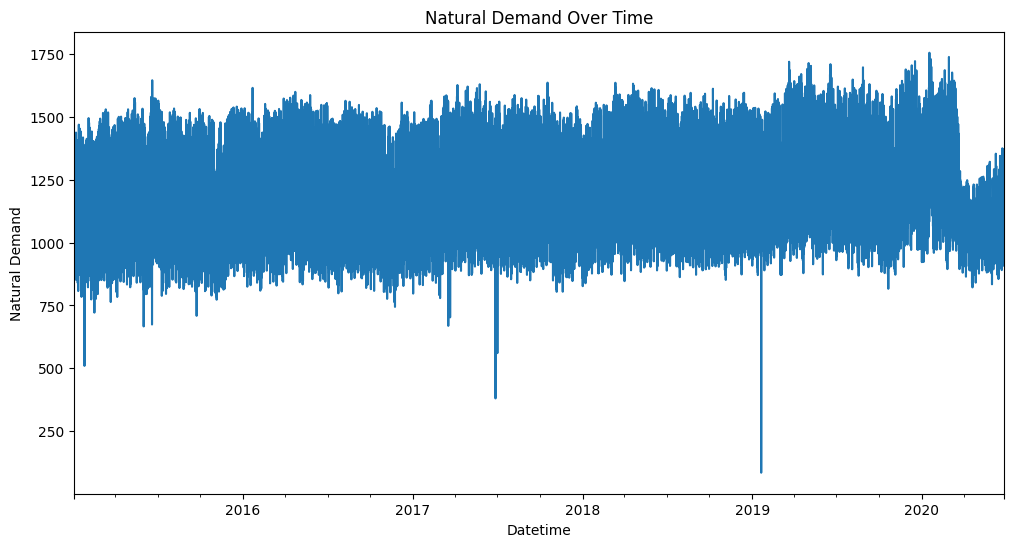

In [ ]:
# Plot nat_demand against datetime
df["nat_demand"].plot(figsize=(12, 6), color=color_pal[0])
plt.title("Natural Demand Over Time")
plt.xlabel("Datetime")
plt.ylabel("Natural Demand")
plt.show()

As you can see that the above plot isn't that really helpful in allowing us to identify any general trends about how the demand of electricity varies on a year-to-year basis. Lets try to capture the general trends about how the demand of electricity varies on a year-to-year basis by averaging our data. We fit a 60 day rolling average and try to make sense of the rolling window. See the plot below.

It can observed that load growth over the years 2015 through 2019 is generally stable, but there is a severe dip in year 2020 due to Covid 19

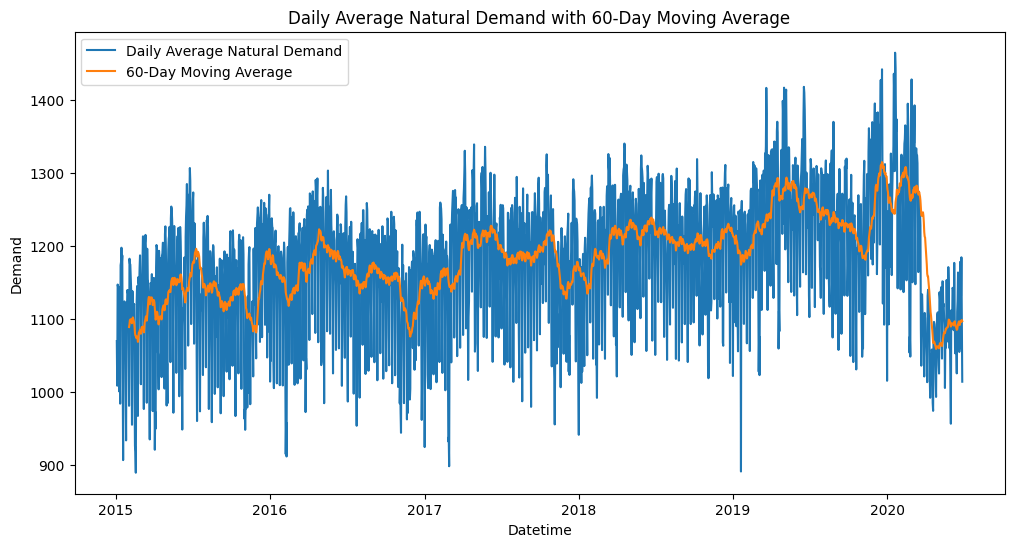

In [ ]:
daily_average = df["nat_demand"].resample("D").mean()

moving_average = daily_average.rolling(window=30).mean()

# Plot the daily average natural demand and the 60-day moving average
plt.figure(figsize=(12, 6))
plt.plot(daily_average, label='Daily Average Natural Demand', color=color_pal[0])
plt.plot(moving_average, label='60-Day Moving Average', color=color_pal[1])

plt.title("Daily Average Natural Demand with 60-Day Moving Average")
plt.xlabel("Datetime")
plt.ylabel("Demand")
plt.legend()
plt.show()

### Monthly Trends

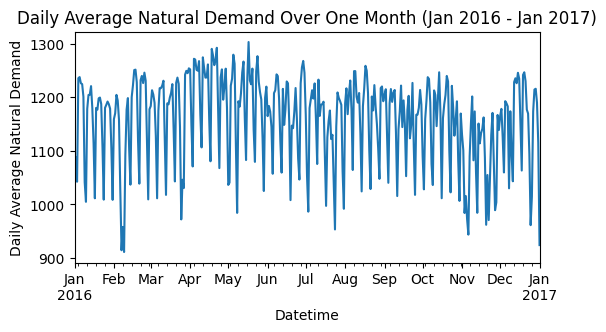

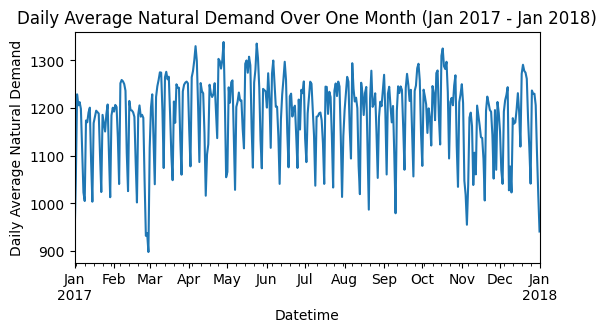

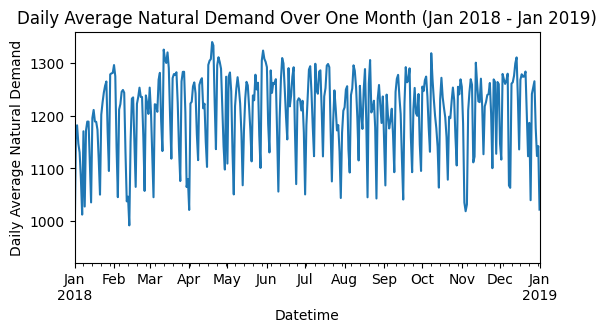

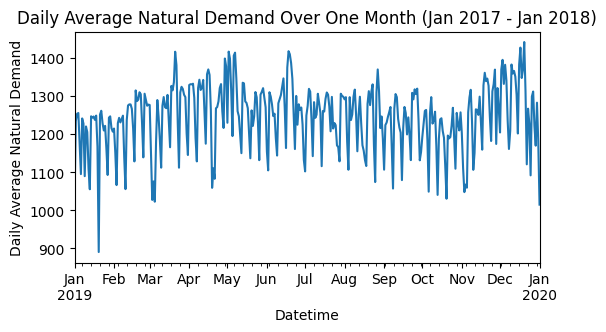

In [ ]:
# For year 2016-2017
start_date1 = '2016-01-01'
end_date1 = '2017-01-01'

df_month1 = daily_average[start_date1:end_date1]

plt.figure(figsize=(6, 3))
df_month1.plot(color=color_pal[0])
plt.title("Daily Average Natural Demand Over One Month (Jan 2016 - Jan 2017)")
plt.xlabel("Datetime")
plt.ylabel("Daily Average Natural Demand")
plt.show()

# For year 2017-2018
start_date2 = '2017-01-01'
end_date2 = '2018-01-01'

df_month2 = daily_average[start_date2:end_date2]

plt.figure(figsize=(6, 3))
df_month2.plot(color=color_pal[0])
plt.title("Daily Average Natural Demand Over One Month (Jan 2017 - Jan 2018)")
plt.xlabel("Datetime")
plt.ylabel("Daily Average Natural Demand")
plt.show()

# For year 2018-2019
start_date3 = '2018-01-01'
end_date3 = '2019-01-01'

df_month3 = daily_average[start_date3:end_date3]

plt.figure(figsize=(6, 3))
df_month3.plot(color=color_pal[0])
plt.title("Daily Average Natural Demand Over One Month (Jan 2018 - Jan 2019)")
plt.xlabel("Datetime")
plt.ylabel("Daily Average Natural Demand")
plt.show()

# For year 2019-2020
start_date4 = '2019-01-01'
end_date4 = '2020-01-01'

df_month4 = daily_average[start_date4:end_date4]

plt.figure(figsize=(6, 3))
df_month4.plot(color=color_pal[0])
plt.title("Daily Average Natural Demand Over One Month (Jan 2017 - Jan 2018)")
plt.xlabel("Datetime")
plt.ylabel("Daily Average Natural Demand")
plt.show()

## Weekly Data

Lets consider what one single week of data looks like. Firstly, we consider the 7-day interval from January 3rd 2017 to January 10th.

In the plot below, we see that there are two different peaks in energy consumption per day. Furthermore, there are valleys during the night.

The general trend is that we have five major peaks on Weekdays and then the energy demand dips down on Saturday and reaches an all time low on a weekly basis for Sunday.

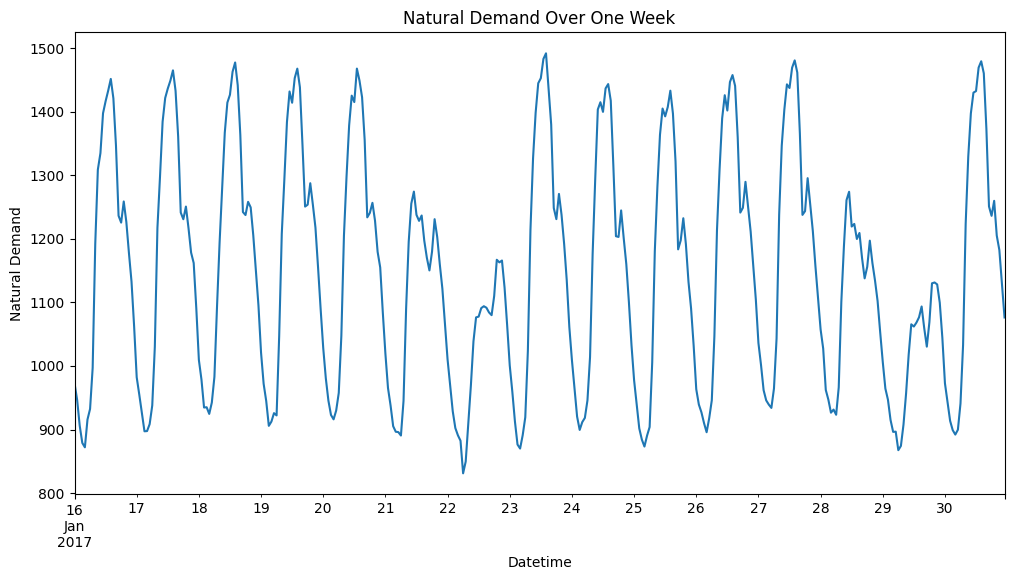

In [ ]:
start_date = '2017-01-16'
end_date = '2017-01-30'

df_week = df[start_date:end_date]

df_week["nat_demand"].plot(figsize=(12, 6), color=color_pal[0])
plt.title("Natural Demand Over One Week")
plt.xlabel("Datetime")
plt.ylabel("Natural Demand")
plt.show()

# Feature Engineering

To understand the significance of a feature in helping us perform accurate forcasting, we must consider the following:

1. **Correlation** with the target - Features highly correlated with the target variable are likely to be more informative for forecasting, as they exhibit a strong relationship with the outcome.
2. **Redundancy among regressor** - Redundant features can introduce noise and complexity without adding new information. Removing redundant features can improve model efficiency and interpretability.Techniques such as variance inflation factor (VIF) or mutual information can be used to identify and eliminate highly correlated features. VIF helps to identify multicollinearity among features in regression models.
3. **Feature importance** - Some models provide a built-in feature importance score. Features with higher importance scores are considered more influential in predicting the target variable.

Given an hour, h, to forecast the load, L, at this hour, $L_h$, and denoting lags in historical load by
$L_{h-i}$. The associated paper with this dataset identifies the following as the most important features.
1. $L_{h-168}$
2. $L_{h-336}$
3. $L_{h-504}$
4. $L_{h-672}$
5. $LMA_{h-168}$
6. $LMA_{h-336}$
5. month_of_the_year
6. day_of_the_weekh
7. weekend_ indicatorh
8. holiday_indicatorh
9. hour_of _the_day
10. temperature _2m_in_Panama_cityh
11. rel_humidity_2m_in_Panama_cityh


From the correlation matrix below, we can see that the correlation of T2M_toc and T2M_dav are the highest and therefore they are the most important variables in predicting electricity demand (besides the time-regressed features). This is visualized by the plot below also.

In [ ]:
correlation_matrix = df.corrwith(df["nat_demand"])
print("Correlation Matrix:")
print(correlation_matrix)



Correlation Matrix:
nat_demand    1.000000
T2M_toc       0.652811
QV2M_toc     -0.036706
TQL_toc       0.073109
W2M_toc       0.098435
T2M_san       0.627024
QV2M_san      0.022172
TQL_san       0.119038
W2M_san       0.191796
T2M_dav       0.648279
QV2M_dav     -0.002117
TQL_dav       0.042037
W2M_dav      -0.054802
Holiday_ID   -0.129834
holiday      -0.165673
school        0.040044
dtype: float64


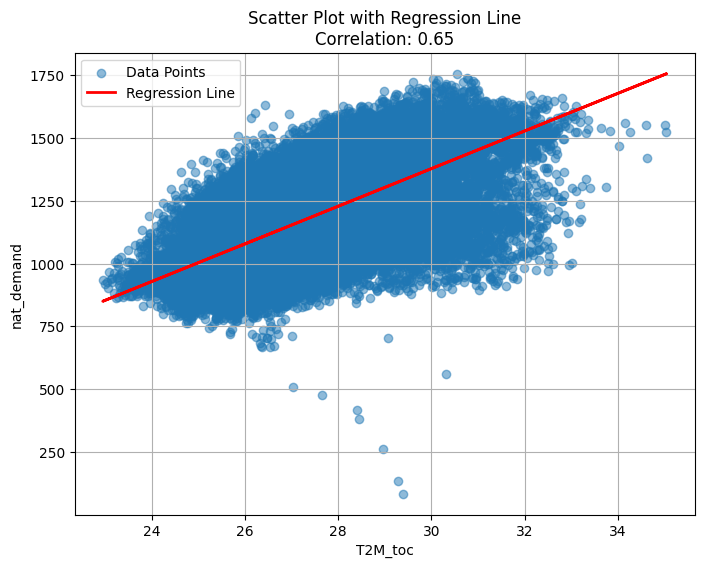

In [ ]:
from sklearn.linear_model import LinearRegression

correlation_coefficient = df["nat_demand"].corr(df["T2M_toc"])

plt.figure(figsize=(8, 6))
plt.scatter(df["T2M_toc"], df["nat_demand"], alpha=0.5, label='Data Points')

model = LinearRegression()
X = df["T2M_toc"].values.reshape(-1, 1)
y = df["nat_demand"].values
model.fit(X, y)

plt.plot(df["T2M_toc"], model.predict(X), color='red', linewidth=2, label='Regression Line')

plt.title(f'Scatter Plot with Regression Line\nCorrelation: {correlation_coefficient:.2f}')
plt.xlabel('T2M_toc')
plt.ylabel('nat_demand')
plt.legend()
plt.grid(True)
plt.show()